<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/img_quality/Automated_Photo_Quality_Curation_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the environment

In [3]:
# check if GPU is available
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [17]:
!pip install fastai dataclasses

# Setup the data access

KonIQ-10k Image Database: http://database.mmsp-kn.de/koniq-10k-database.html
10,073 images, on which we performed very large scale crowdsourcing experiments in order to obtain reliable quality ratings from 1,467 crowd workers (1.2 million ratings).

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!ls -la /content/drive/ | head

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
total 20
dr-x------  2 root root 4096 Mar 15 16:37 .file-revisions-by-id
drwx------ 12 root root 4096 Mar 15 16:37 MyDrive
drwx------  2 root root 4096 Mar 15 16:37 Othercomputers
dr-x------  2 root root 4096 Mar 15 16:37 .shortcut-targets-by-id
drwx------  5 root root 4096 Mar 15 16:37 .Trash-0


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

In [4]:
PATH=Path("/content/drive/My Drive/Datasets/KonIQ10K")

### First time run
We download and unzip the traingin image dataset from source and store it in our mounted drive so that we would be able to retrieve it faster next time we need to re-initialize the runtime environment.

In [5]:
!mkdir -p "{PATH}"
!cd "{PATH}"

# download images
!wget "https://www.dropbox.com/s/61nzdu0p8vn9vk6/koniq10k_1024x768.zip?dl=1" \
 --quiet --show-progress -O koniq10k_1024x768.zip &&\
 unzip -qq koniq10k_1024x768.zip &&\
 rm koniq10k_1024x768.zip

# download scores
!wget "http://datasets.vqa.mmsp-kn.de/archives/koniq10k_scores_and_distributions.zip" \
 --quiet --show-progress -O koniq10k_scores_and_distributions.zip &&\
 unzip -qq koniq10k_scores_and_distributions.zip &&\
 rm koniq10k_scores_and_distributions.zip

koniq10k_1024x768.z 100%[===================>]   5.22G  44.4MB/s    in 96s     
koniq10k_scores_and 100%[===================>] 296.40K   892KB/s    in 0.3s    


In [6]:
!ls -la "{PATH}"

total 0


In [8]:
# Lets look at the data labels
df = pd.read_csv(PATH/'koniq10k_scores_and_distributions.csv')
df.head()

FileNotFoundError: ignored

(array([  32.,  136.,  313.,  627.,  922., 1359., 2070., 2842., 1657.,
         115.]),
 array([1.09615385, 1.41753846, 1.73892308, 2.06030769, 2.38169231,
        2.70307692, 3.02446154, 3.34584615, 3.66723077, 3.98861538,
        4.31      ]),
 <a list of 10 Patch objects>)

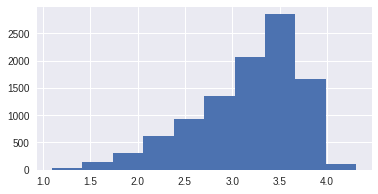

In [ ]:
# Look at the distribution of Mean Opinion Scores (MOS) 
plt.figure(figsize=(6,3))
plt.hist(df['MOS'].values)

(array([  32.,  136.,  313.,  627.,  922., 1359., 2070., 2842., 1657.,
         115.]),
 array([2.19230769, 2.83507692, 3.47784615, 4.12061538, 4.76338462,
        5.40615385, 6.04892308, 6.69169231, 7.33446154, 7.97723077,
        8.62      ]),
 <a list of 10 Patch objects>)

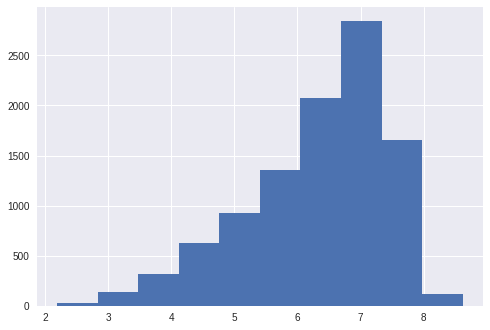

In [ ]:
# Rescale the MOS to a 0-10 score base
df['MOS'] = df['MOS']*2
plt.hist(df['MOS'].values)

In [ ]:
# Save processed data labels
df.to_csv(PATH/'koniq10k_scores_and_distributions.10scale.csv', index=False, columns=['image_name', 'MOS'])
df = pd.read_csv(PATH/'koniq10k_scores_and_distributions.10scale.csv')
df.head()

image_name       MOS
0  10004473376.jpg  7.657143
1  10007357496.jpg  6.958333
2  10007903636.jpg  7.562500
3  10009096245.jpg  7.853211
4    100117038.jpg  7.660000

# Training

## Preparing Training and Validation datasets

In [ ]:
import fastai
from fastai import *           # common functionality
from fastai.vision import *    # computer vision functionality
from fastai.callbacks import * # training cycle callbacks

In [ ]:
# Training dataset transformations
get_transforms(do_flip=True, flip_vert=False, max_rotate=5.0, max_zoom=0., max_warp=False, max_lighting=False)

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-5.0, 5.0)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

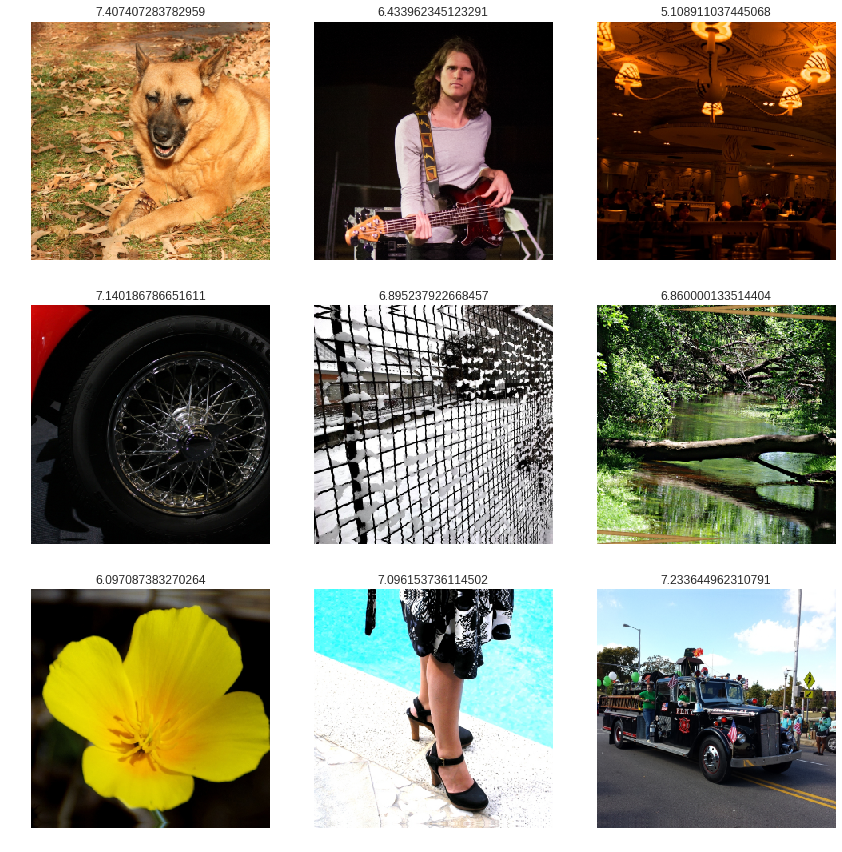

In [ ]:
# We split the 10K samples into training and validation sets
data = ImageDataBunch.from_csv(
    path=PATH,         # path to the dataset
    folder='1024x768', # folder with images
    csv_labels='koniq10k_scores_and_distributions.10scale.csv',
    fn_col=0,          # file name column index
    label_col=1,       # index of the labels
    valid_pct=0.10,    # percentage of samples to use for the validation
    size=299,          # all images are resized to this size
    bs=128,            # the number of images in a traing batch size, change to fit into GPU memory
    ds_tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=5.0, max_zoom=0., max_warp=False, max_lighting=False)
).normalize(imagenet_stats)

# Looking at the training data sample
data.show_batch(rows=3)

In [ ]:
# mean absolute percentage error
def mape(preds, targs):
    return (np.abs((targs - preds) / targs)).mean() * 100

# create a CNN model with weights pre-initialized from ImageNet training
learn = create_cnn(data, models.resnet34)

# add validation metrics to track progress
learn.metrics = [mape]

# add callback to automatically save model weights when MAPE metric improves
#learn.callbacks.append(SaveModelCallback(learn, 
#                                          every='improvement',
#                                          monitor='mape',
#                                          mode='min',
#                                          name='quality-size299-resnet34-scale10-best'
#                                         ))

# add callback to plot trainig and validation losses during training cycle
learn.callbacks.append(ShowGraph(learn))

# add callback to freeze moving average statistics in all non-trainable batchnorm layers
learn.callbacks.append(BnFreeze(learn))

In [ ]:
# let's increase the dropout percentage on the last layers to reduce overfitting
learn.model[1][3].p = 0.4
learn.model[1][7].p = 0.6
# let's now look at the last layer of the NN that we will be training
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.4)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.6)
  (8): Linear(in_features=512, out_features=1, bias=True)
)

## Initial training

![ResNet50](https://3.bp.blogspot.com/-8Lsg0rnxl7k/WRtttN18MKI/AAAAAAAAB0o/KpHbFnYBmTYQ3dBjVLimPUkKphU_qLBfgCLcB/s640/image2.png)

With most of the initial ImageNet trained Resnet34 CNN has it's weights frozen we start training just the last fully connected layers.

First we start the pretraining with relatively large learning rate to let the inital loss reduce quickly.

We proceed with [1cycle training policy](https://sgugger.github.io/the-1cycle-policy.html) to get the losses to the point of overfitting. 


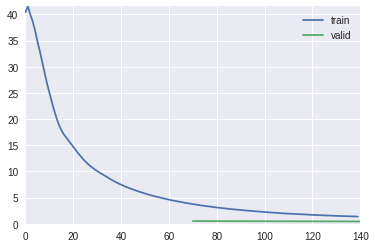

In [ ]:
# set initial learning rate, use lr_finder to guess this better
lr = 0.01

# training cycle
learn.fit(2, lr)

In [ ]:
learn.save("quality-size299-resnet34-scale10-init")

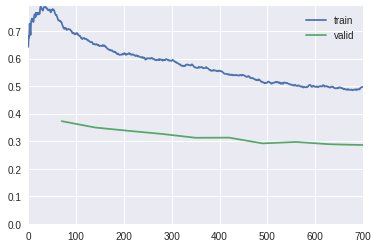

In [ ]:
# reduce a learning rate
lr = 0.001

# training with the 1cycle policy
learn.fit_one_cycle(10,lr)

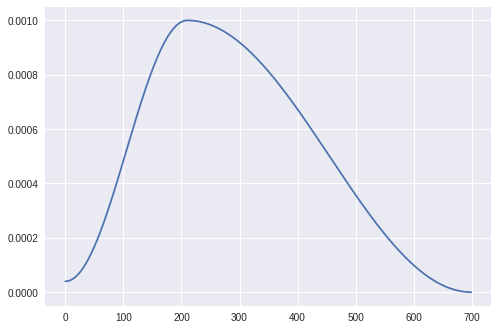

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save("quality-size299-resnet34-scale10-step1")

## Discriminative-layer-training cycle
https://docs.fast.ai/basic_train.html#Discriminative-layer-training

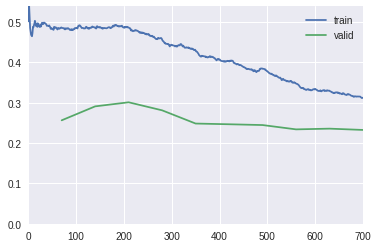

In [ ]:
learn.load("quality-size299-resnet34-scale10-step1")
data.batch_size = 128
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=(1e-5, 1e-4, 1e-3), wd=(1e-5, 1e-4, 1e-3))

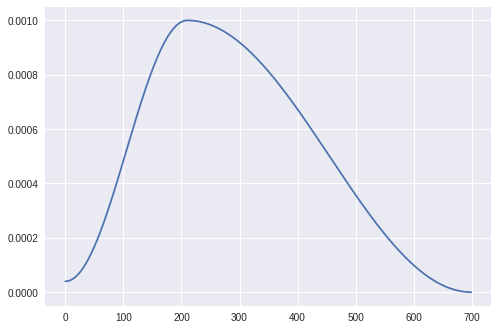

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save("quality-size299-resnet34-scale10-step2")

In [ ]:
learn.load("quality-size299-resnet34-scale10-step2")
data.batch_size = 128
learn.unfreeze()
# let's decrease the dropout rate 
learn.model[1][3].p = 0.25
learn.model[1][7].p = 0.5
learn.fit_one_cycle(3, max_lr=(1e-6, 1e-5, 1e-4), wd=(1e-6, 1e-5, 1e-4))
learn.save("quality-size299-resnet34-scale10-step3")

In [ ]:
# Let's now give network more pixels to look at by increasing the image size
data = ImageDataBunch.from_csv(
    path=PATH,         # path to the dataset
    folder='1024x768', # folder with images
    csv_labels='koniq10k_scores_and_distributions.10scale.csv',
    fn_col=0,          # file name column index
    label_col=1,       # index of the labels
    valid_pct=0.10,    # percentage of samples to use for the validation
    size=512,          # all images are resized to this size
    bs=64,             # the number of images in a traing batch size, change to fit into GPU memory
    ds_tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=5.0, max_zoom=0., max_warp=False, max_lighting=False)
).normalize(imagenet_stats)
learn.data = data
learn.load("quality-size299-resnet34-scale10-step3")
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=(1e-6, 1e-5, 1e-4), wd=(1e-6, 1e-5, 1e-4))
learn.save("quality-size512-resnet34-scale10-step4")

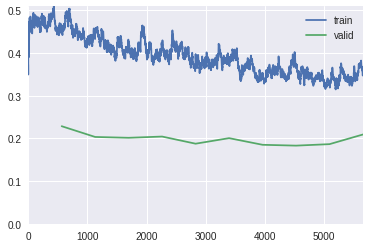

In [ ]:
learn.load("quality-size512-resnet34-scale10-step4")
# Let's now give network more pixels to look at by increasing the image size
data = ImageDataBunch.from_csv(
    path=PATH,         # path to the dataset
    folder='1024x768', # folder with images
    csv_labels='koniq10k_scores_and_distributions.10scale.csv',
    fn_col=0,          # file name column index
    label_col=1,       # index of the labels
    valid_pct=0.10,    # percentage of samples to use for the validation
    size=1024,         # all images are resized to this size
    bs=16,             # the number of images in a traing batch size, change to fit into GPU memory
    ds_tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=5.0, max_zoom=0., max_warp=False, max_lighting=False)
).normalize(imagenet_stats)
learn.data = data
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=(1e-7, 1e-5, 1e-4), wd=(1e-7, 1e-5, 1e-4))
learn.save("quality-size1024-resnet34-scale10-step5")

# Validation and Results

In [ ]:
# initialize the model
learn = create_cnn(data, models.resnet34)
# initialize the date
data = ImageDataBunch.from_csv(
    path=PATH,         # path to the dataset
    folder='1024x768', # folder with images
    csv_labels='koniq10k_scores_and_distributions.10scale.csv',
    fn_col=0,          # file name column index
    label_col=1,       # index of the labels
    valid_pct=0.10,    # percentage of samples to use for the validation
    size=1024,         # all images are resized to this size
    bs=16,             # the number of images in a traing batch size, change to fit into GPU memory
    ds_tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=5.0, max_zoom=0., max_warp=False, max_lighting=False)
).normalize(imagenet_stats)
learn.data = data
# load trained weights
learn.load("quality-size1024-resnet34-scale10-step5")
# export data setup for inference
data.export("quality-size1024-resnet34-scale10-data.pkl")

(array([431., 311., 164.,  61.,  24.,   7.,   5.,   2.,   1.,   1.]),
 array([1.110758e-03, 3.364077e+00, 6.727044e+00, 1.009001e+01, 1.345298e+01, 1.681594e+01, 2.017891e+01, 2.354188e+01,
        2.690484e+01, 3.026781e+01, 3.363078e+01]),
 <a list of 10 Patch objects>)

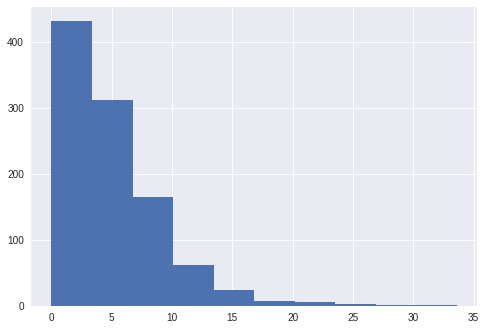

In [ ]:
# get validation dataset predictions
preds, targs = learn.get_preds()
preds = np.squeeze(preds)
# average percentage error
ape = np.abs((targs - preds) / targs)*100
# plot historgam for APE
plt.hist(ape)

In [ ]:
learn.load("quality-size299-resnet34-scale10-step3")
learn.callbacks = []
learn.validate()

[3.7625294, tensor(30.1353)]

In [ ]:
learn.load("quality-size512-resnet34-scale10-step4")
learn.callbacks = []
learn.validate()

[1.5244389, tensor(23.3926)]

In [ ]:
learn.load("quality-size1024-resnet34-scale10-step5")
learn.callbacks = []
learn.validate()

[0.14829336, tensor(19.7399)]

In [ ]:
d = pd.DataFrame.from_items([
    ('idx', range(0, len(targs))), 
    ('mos', targs), 
    ('pred', preds),
    ('e', ape),
]) 
n = d['idx'].count()
k = 10
d = d.sort_values('e', ascending=True).reset_index(drop=True)
d

idx       mos      pred          e
0     278  7.126214  7.126293   0.001111
1     560  6.444445  6.443969   0.007377
2     622  4.915888  4.916337   0.009137
3     332  6.919708  6.918273   0.020735
4       3  6.194690  6.193057   0.026364
5     348  7.407407  7.404540   0.038714
6     156  7.056604  7.059440   0.040193
7     634  6.181818  6.184387   0.041553
8     202  6.868687  6.863434   0.076475
9     958  7.284404  7.290504   0.083750
10    671  6.566038  6.560391   0.085991
11    986  7.363636  7.371027   0.100358
12    918  6.784314  6.777484   0.100670
13    404  4.096154  4.091962   0.102325
14    590  6.471698  6.478373   0.103130
15    552  6.745454  6.738132   0.108545
16     42  6.679612  6.687497   0.118053
17    544  6.873016  6.863971   0.131603
18    261  6.185185  6.193542   0.135122
19    455  6.541935  6.533083   0.135319
20    465  7.244898  7.255018   0.139690
21    145  6.373832  6.363791   0.157523
22    276  7.850467  7.838021   0.158543
23    801  7.238095  7.224821   0.183400
24    758  7.415094  7.429318   0.191826
25    780  4.690909  4.681013   0.210957
26    734  7.132075  7.147303   0.213511
27    131  5.919192  5.931933   0.215259
28    579  5.656250  5.668686   0.219861
29    114  7.567010  7.583829   0.222261
...   ...       ...       ...        ...
977   190  6.081633  5.186264  14.722504
978   912  5.177570  5.942131  14.766787
979    65  4.442307  3.782845  14.845032
980   891  3.757009  4.324520  15.105375
981   519  5.636364  4.784019  15.122242
982   574  6.238532  5.278065  15.395726
983   683  4.961538  5.728951  15.467241
984   530  6.686275  5.642860  15.605314
985   875  5.420561  4.558562  15.902395
986   629  8.091743  6.797048  16.000208
987    81  4.297029  4.996389  16.275427
988    22  4.740741  3.956665  16.539097
989    75  4.039216  3.370027  16.567301
990   476  5.165049  4.298352  16.780024
991   882  5.085714  4.227845  16.868214
992   502  7.171171  5.941074  17.153368
993   992  5.188679  6.119769  17.944641
994   338  6.476191  5.290502  18.308426
995   745  3.500000  4.166123  19.032097
996   608  5.388889  4.347259  19.329212
997   340  5.320000  4.268466  19.765680
998    49  3.126214  3.790026  21.233767
999   542  2.990099  3.637706  21.658390
1000  627  3.245283  3.967835  22.264692
1001  506  3.482143  4.290149  23.204283
1002  827  4.784314  5.906689  23.459488
1003  787  5.834862  7.224349  23.813524
1004  952  4.484848  5.600552  24.877174
1005  317  2.740741  3.564670  30.062277
1006  265  4.000000  5.345231  33.630775

[1007 rows x 4 columns]

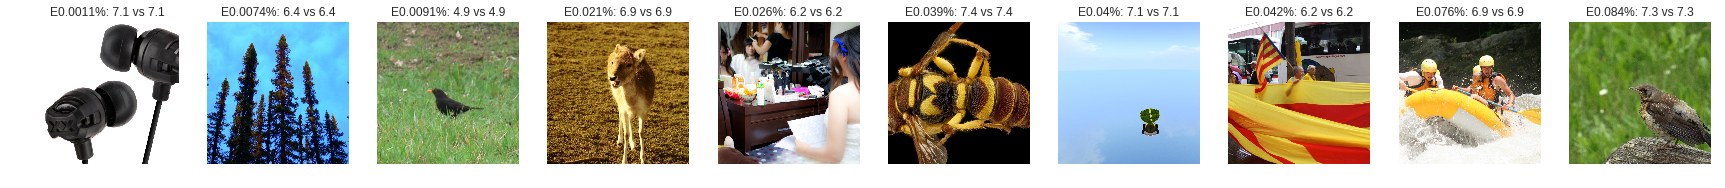

In [ ]:
# best prediction accuracy
_,axs = plt.subplots(1,k,figsize=(30,5))
for i,idx in enumerate(d['idx'][:10]):
  learn.data.valid_ds[idx][0].show(ax=axs[i], title=f"E{d['e'][i]:0.2f}%: {d['pred'][i]:.2} vs {d['mos'][i]:.2}")

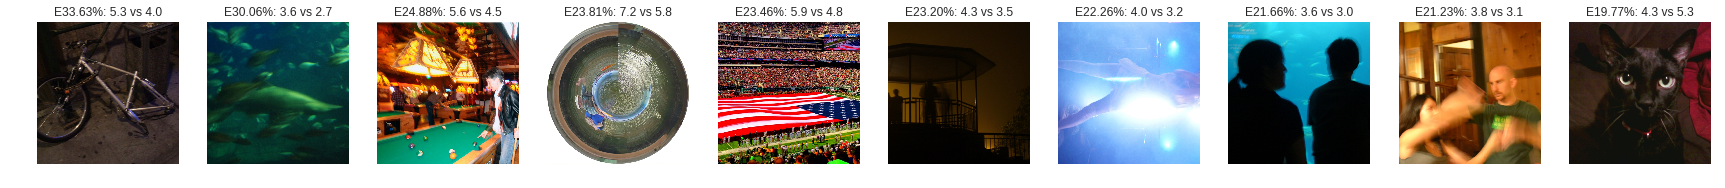

In [ ]:
# worst prediction accuracy
d = d.sort_values('e', ascending=False).reset_index(drop=True)
_,axs = plt.subplots(1,k,figsize=(30,5))
for i,idx in enumerate(d['idx'][:10]):
  learn.data.valid_ds[idx][0].show(ax=axs[i], title=f"E{d['e'][i]:0.2f}%: {d['pred'][i]:.2} vs {d['mos'][i]:.2}")

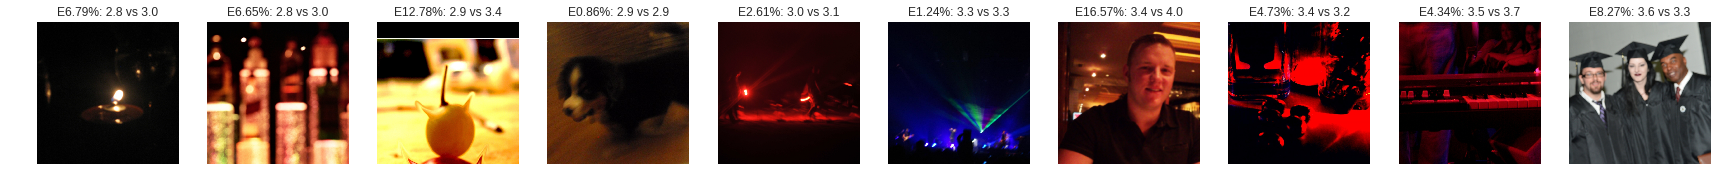

In [ ]:
# lowest predicted score
d = d.sort_values('pred', ascending=True).reset_index(drop=True)
_,axs = plt.subplots(1,k,figsize=(30,5))
for i,idx in enumerate(d['idx'][:10]):
  learn.data.valid_ds[idx][0].show(ax=axs[i], title=f"E{d['e'][i]:0.2f}%: {d['pred'][i]:.2} vs {d['mos'][i]:.2}")

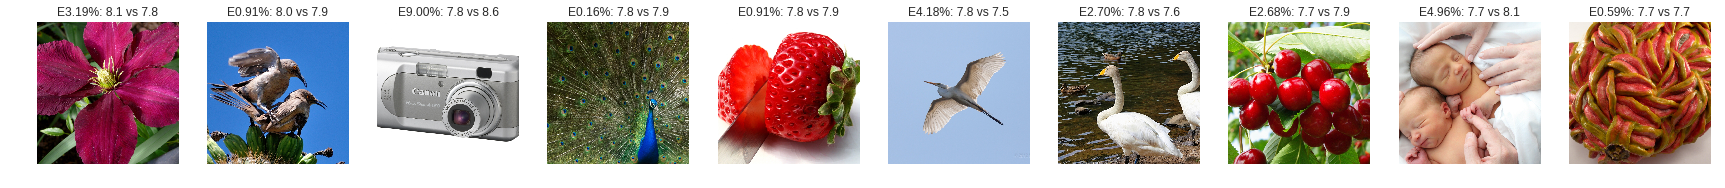

In [ ]:
# highest predicted score
d = d.sort_values('pred', ascending=False).reset_index(drop=True)
_,axs = plt.subplots(1,k,figsize=(30,5))
for i,idx in enumerate(d['idx'][:10]):
  learn.data.valid_ds[idx][0].show(ax=axs[i], title=f"E{d['e'][i]:0.2f}%: {d['pred'][i]:.2} vs {d['mos'][i]:.2}")

# Testing with your images

In [11]:
!pip uninstall torchvision
!pip install torchvision==0.4.0 -f https://download.pytorch.org/whl/torch_stable.html


Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.11.1+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.7be20469.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.8313e8da.so.11
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libz.1328edc3.so.1
    /usr/local/lib/python3.7/dist-packages/torchvision/*
Proceed (y/n)? y
  Successfully uninstalled torchvision-0.11.1+cu111
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 8.8 MB 47.2 MB/s 
     |████████████████████████████████| 663.1 MB 1.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111

In [14]:
!pip3 install 'pillow<7.0.0'

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.2.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import fastai
from fastai import *           # common functionality
from fastai.vision import *    # computer vision functionality
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# initialize a model for inference
PATH = Path("/content/drive/My Drive/Datasets/KonIQ10K")
empty = ImageDataBunch.load_empty(PATH, "quality-size1024-resnet34-scale10-data.pkl", tfms=get_transforms())
learn = create_cnn(empty, models.resnet34)
learn.load("quality-size1024-resnet34-scale10-step5")

TypeError: ignored

In [ ]:
image_dir = Path("/content/uploads")

In [ ]:
# get a sample image
!mkdir -p "{image_dir}"
!wget "https://unsplash.com/photos/l5truYNKmm8/download?force=true" -qq -O "{image_dir}/cat.jpg"
!wget "https://unsplash.com/photos/peGGjnkMRwo/download?force=true" -qq -O "{image_dir}/rain.jpg"
!wget "https://unsplash.com/photos/8uXthE3xeBI/download?force=true" -qq -O "{image_dir}/scape.jpg"
!ls -la "{image_dir}"

In [ ]:
# load images and run model inference
image_list = ImageItemList.from_folder(image_dir)
_,axs = plt.subplots(1,len(image_list))
for i,img in enumerate(image_list):
  sample = img.resize(1024).refresh()
  pred = learn.predict(sample)
  score = pred[0].obj
  sample.show(ax=axs[i], title=f"#{i}: {score:0.2f}")